In [78]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib


#matplotlib settings for pretty plots

#matplotlib.rc('text',usetex=True)
font = {'family' : 'serif',
#        'weight' : 'bold',
        'size'   : 16,}
matplotlib.rc('font', **font)




SORTING BY BEST MATCH TO DISTRIBUTION:

Order Num										DiffFromCar	DiffFromDist
--		Size (ft):	8	10	12	14	16	18	20	--		--
1		Quantity:	3	5	8	10	8	5	2	7.0		2.13


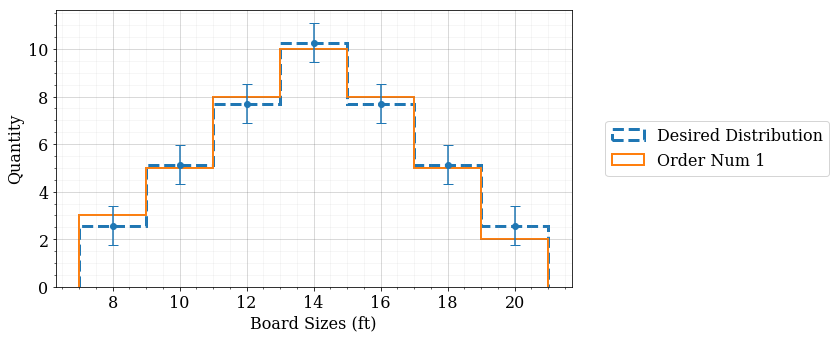



SORTING BY BEST RAILCAR PACKING:

Order Num										DiffFromCar	DiffFromDist
--		Size (ft):	8	10	12	14	16	18	20	--		--
1		Quantity:	2	5	8	11	8	5	2	1.0		2.73
2		Quantity:	3	5	8	9	8	5	3	1.0		3.0
3		Quantity:	3	5	7	10	8	6	2	1.0		3.27
4		Quantity:	3	5	7	11	7	5	3	1.0		3.27
5		Quantity:	2	6	8	10	7	5	3	1.0		3.27


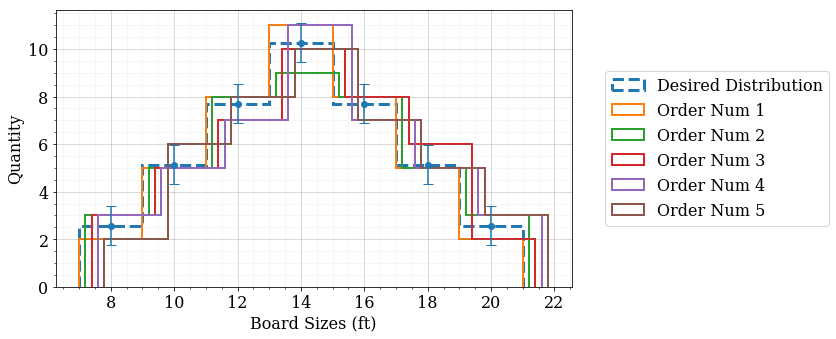

In [300]:
#N_cars = 1 #number of railcars

carlength = 575 #lineal footage of each railcar

possible_lengths = np.array([8,10,12,14,16,18,20]) #possible board lengths
weights =          np.array([1, 2, 3, 4, 3, 2, 1]) #relative amounts of each type of board
#weights =          np.array([1, 1, 1, 1, 1, 1, 1]) #relative amounts of each type of board
#weights = stats.norm(loc=14,scale=4).pdf(possible_lengths)

weights = weights/np.sum(weights)
weight_errs = np.ones_like(weights)*0.02

bins = np.zeros(len(possible_lengths)+1)
bins[1:-1] = 0.5*(possible_lengths[1:]+possible_lengths[:-1])
bins[0] = bins[1]-(possible_lengths[1]-possible_lengths[0])
bins[-1] = bins[-2]+(possible_lengths[-1]-possible_lengths[-2])

#use expectation to get amounts of each board length that fit in the car length
n_avg = carlength/np.sum(weights*possible_lengths)
unrounded_quantities = n_avg*weights
rounded_quantities = np.round(unrounded_quantities,0).astype(int) #round to integers for first guess

final_quantities = np.copy(rounded_quantities)
final_length = np.sum(rounded_quantities*possible_lengths)
length_diff = carlength-final_length
dist_diff = np.sum(np.abs(unrounded_quantities-final_quantities))

max_show = 5

if length_diff == 0: #perfect
    print('Perfect match to distribution and railcar length found!')
    print('\nOrder Num\t\t\t\t\t\t\t\t\t\tDiffFromCar\tDiffFromDist')
    print('--\t\tSize (ft):\t'+'\t'.join(possible_lengths.astype(str))+'\t--\t\t--')
    print(f'{i+1}\t\tQuantity:\t'+'\t'.join(final_quantities.astype(str))+f'\t{length_diff}\t\t{round(dist_diff,2)}')
    i = 0
    plt.figure(figsize=(12,5))
    plt.hist(possible_lengths,weights=weights*n_avg,bins=bins,histtype='step',lw=3,ls='--',label='Desired Distribution')
    plt.errorbar(possible_lengths,weights*n_avg,yerr=weight_errs*n_avg,fmt='o',color='C0',capsize=5)
    plt.hist(possible_lengths,weights=final_quantities,bins=bins+0.2*i,histtype='step',lw=2,ls='-',label='Order Num %d'%(i+1))
    plt.xlabel('Board Sizes (ft)'); plt.ylabel('Quantity')
    plt.grid(b=True, which='major', color='#666666', linestyle='-',alpha=0.3)
    plt.minorticks_on()
    plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.1)
    plt.legend(loc=6,bbox_to_anchor=(1.05,0.5))
    plt.tight_layout()
    plt.show()
else:
    min_board_quantities = np.ceil(weights*n_avg-weight_errs*n_avg)
    max_board_quantities = np.floor(weights*n_avg+weight_errs*n_avg)    
    
    max_change_quantities = max_board_quantities-min_board_quantities
    
    max_change_quantities_downup = np.zeros((2,len(max_change_quantities)))
    max_change_quantities_downup[:] = np.copy(max_change_quantities)
    max_change_quantities_downup[:,max_change_quantities < 1] = 1
    max_change_quantities_downup[0,(final_quantities-max_change_quantities) <= 0] = 0
    max_change_quantities_downup[:,final_quantities == 0] = 0
    
    lowest_config = final_quantities-max_change_quantities_downup[0] #should always be lower than carlength
    changes_from_lowest = max_change_quantities_downup[1]+max_change_quantities_downup[0]    
    
    poss_changes = []
    for i in range(len(changes_from_lowest)):
        poss_changes.append(np.arange((changes_from_lowest[i]+1)))
    #this part needs to be updated if the number of possible lengths changes
    all_change_configs = np.meshgrid(poss_changes[0],poss_changes[1],poss_changes[2],poss_changes[3],
                            poss_changes[4],poss_changes[5],poss_changes[6],indexing='ij',sparse=False)
    all_change_configs = np.array(all_change_configs).reshape((len(possible_lengths),-1)).T
    remaining_length = carlength-np.sum(lowest_config*possible_lengths)
    
    #for each change config, measure distance from distribution and from carlength
    dist_from_distribution = np.zeros(len(all_change_configs)) 
    dist_from_carlength = np.zeros(len(all_change_configs))

    for i in range(len(all_change_configs)):
        dist_from_carlength[i] = remaining_length-np.sum(all_change_configs[i]*possible_lengths)
        dist_from_distribution[i] = np.sum(np.abs(unrounded_quantities-(lowest_config+all_change_configs[i])))
        
    bad_packing = (dist_from_carlength < 0) #didn't fit in railcar
    dist_from_carlength[bad_packing] = np.inf
    dist_from_distribution[bad_packing] = np.inf
    
    best_packing_length = np.min(dist_from_carlength)
    best_packing_inds = (dist_from_carlength == best_packing_length)
    best_packing_configs = lowest_config+all_change_configs[best_packing_inds]
    #sort best packing configs by the distance from distribution
    sort_inds = np.argsort(dist_from_distribution[best_packing_inds])[:max_show]
    best_packing_configs = best_packing_configs[sort_inds].astype(int)
    best_packing_config_dists = dist_from_distribution[best_packing_inds][sort_inds]
    
    best_dist_match = np.min(dist_from_distribution)
    best_dist_inds = (dist_from_distribution == best_dist_match)
    best_dist_configs = lowest_config+all_change_configs[best_dist_inds]
    #sort best distribution configs by the packing efficiency
    sort_inds = np.argsort(dist_from_carlength[best_dist_inds])[:max_show]
    best_dist_configs = best_dist_configs[sort_inds].astype(int)
    best_dist_config_lengths = dist_from_carlength[best_dist_inds][sort_inds]
    
    print('\nSORTING BY BEST MATCH TO DISTRIBUTION:')
    print('\nOrder Num\t\t\t\t\t\t\t\t\t\tDiffFromCar\tDiffFromDist')
    print('--\t\tSize (ft):\t'+'\t'.join(possible_lengths.astype(str))+'\t--\t\t--')
    for i in range(len(best_dist_configs)):
        print(f'{i+1}\t\tQuantity:\t'+'\t'.join(best_dist_configs[i].astype(str))+f'\t{best_dist_config_lengths[i]}\t\t{round(best_dist_match,2)}')

    plt.figure(figsize=(12,5))
    plt.hist(possible_lengths,weights=weights*n_avg,bins=bins,histtype='step',lw=3,ls='--',label='Desired Distribution')
    plt.errorbar(possible_lengths,weights*n_avg,yerr=weight_errs*n_avg,fmt='o',color='C0',capsize=5)
    for i in range(len(best_dist_configs)):
        plt.hist(possible_lengths,weights=best_dist_configs[i],bins=bins+0.2*i,histtype='step',lw=2,ls='-',label='Order Num %d'%(i+1))
    plt.xlabel('Board Sizes (ft)'); plt.ylabel('Quantity')
    plt.grid(b=True, which='major', color='#666666', linestyle='-',alpha=0.3)
    plt.minorticks_on()
    plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.1)
    plt.legend(loc=6,bbox_to_anchor=(1.05,0.5))
    plt.tight_layout()
    plt.show()
    
    print('\n\nSORTING BY BEST RAILCAR PACKING:')
    print('\nOrder Num\t\t\t\t\t\t\t\t\t\tDiffFromCar\tDiffFromDist')
    print('--\t\tSize (ft):\t'+'\t'.join(possible_lengths.astype(str))+'\t--\t\t--')
    for i in range(len(best_packing_configs)):
        print(f'{i+1}\t\tQuantity:\t'+'\t'.join(best_packing_configs[i].astype(str))+f'\t{best_packing_length}\t\t{round(best_packing_config_dists[i],2)}')

    plt.figure(figsize=(12,5))
    plt.hist(possible_lengths,weights=weights*n_avg,bins=bins,histtype='step',lw=3,ls='--',label='Desired Distribution')
    plt.errorbar(possible_lengths,weights*n_avg,yerr=weight_errs*n_avg,fmt='o',color='C0',capsize=5)
    for i in range(len(best_packing_configs)):
        plt.hist(possible_lengths,weights=best_packing_configs[i],bins=bins+0.2*i,histtype='step',lw=2,ls='-',label='Order Num %d'%(i+1))
    plt.xlabel('Board Sizes (ft)'); plt.ylabel('Quantity')
    plt.grid(b=True, which='major', color='#666666', linestyle='-',alpha=0.3)
    plt.minorticks_on()
    plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.1)
    plt.legend(loc=6,bbox_to_anchor=(1.05,0.5))
    plt.tight_layout()
    plt.show()

